In [1]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b as b
import math

In [2]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [3]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [4]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    Delta = (ec12 - ec23)/ec13
    mu = (mu3-mu1)/(mu1+mu3)
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    
    # coefficients for S1'
    c_e12 = -(mu1+mu3)**2*mu1*a + 16*mu2*Delta*mu1**2
    c_e23 = (mu1+mu3)**2*mu3*b + 16*mu2*Delta*mu3**2
    c1, c2, c3 = -c_e12, (c_e12-c_e23), c_e23
    
    # coefficients for S2'
    c_e13 = (mu3-mu1*mu2)*b + (mu1-mu2*mu3)*a
    c_eminus = -16*mu2*Delta
    d1, d2, d3 = -c_e13+c_eminus*mu1, -c_eminus*(mu1+mu3), c_e13+c_eminus*mu3
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    S1ax, S1ay, S2ax, S2ay = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
        
        S1ax[i] = c1*ps[1].e*np.cos(-ps[1].pomega) + c2*ps[2].e*np.cos(-ps[2].pomega) + c3*ps[3].e*np.cos(-ps[3].pomega)
        S1ay[i] = c1*ps[1].e*np.sin(-ps[1].pomega) + c2*ps[2].e*np.sin(-ps[2].pomega) + c3*ps[3].e*np.sin(-ps[3].pomega)
        S2ax[i] = d1*ps[1].e*np.cos(-ps[1].pomega) + d2*ps[2].e*np.cos(-ps[2].pomega) + d3*ps[3].e*np.cos(-ps[3].pomega)
        S2ay[i] = d1*ps[1].e*np.sin(-ps[1].pomega) + d2*ps[2].e*np.sin(-ps[2].pomega) + d3*ps[3].e*np.sin(-ps[3].pomega)
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T
    
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a = np.sqrt(S1ax**2 + S1ay**2)
    S2a = np.sqrt(S2ax**2 + S2ay**2)
    S3a = S3
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

# Mode Approximation

In [5]:
def calcMode(sim):
    ps = sim.particles
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    Delta = (ec12 - ec23)/ec13
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    
    c_e12 = -(mu1+mu3)**2*mu1*a + 16*mu2*Delta*mu1**2
    c_e23 = (mu1+mu3)**2*mu3*b + 16*mu2*Delta*mu3**2
    c1, c2, c3 = -c_e12, (c_e12-c_e23), c_e23
    
    c_e13 = (mu3-mu1*mu2)*b + (mu1-mu2*mu3)*a
    c_eminus = -16*mu2*Delta
    d1, d2, d3 = -c_e13+c_eminus*mu1, -c_eminus*(mu1+mu3), c_e13+c_eminus*mu3
    
    return 1/np.sqrt(c1**2+c2**2+c3**2) * np.array([c1, c2, c3]), 1/np.sqrt(d1**2+d2**2+d3**2) * np.array([d1, d2, d3])

In [243]:
def calcPsi(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    psi_theo = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    
    Delta = (ec12 - ec23)/ec13
    mu = (mu3-mu1)/(mu1+mu3)
    a = (1-Delta)**3*(3+Delta)
    b = (1+Delta)**3*(3-Delta)
    
    psi_approx = -16*sqrt(mu1*mu2*mu3)*Delta/(a*(mu1+mu3)+16*mu3*Delta-mu2*((mu1+mu3)*b-16*mu3*Delta))
    return Delta, psi_theo, psi_approx

In [7]:
from sympy import *
init_printing()
M1, M2, M3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13, e1, e2, e3 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}, e_1, e_2, e_3", positive=True, real=True)
eps12, eps23, eps13 = symbols(r"\epsilon_{12}, \epsilon_{23}, \epsilon_{13}", positive=True, real=True)

G = Matrix([sqrt(M1)*e1, sqrt(M2)*e2, sqrt(M3)*e3])

In [8]:
# normalized coefficients in front of e1, e2, and e3 (i.e., unit vector in e1, e2 and e3 bases)
def convert(x):
    coeff1 = x.split("*e_1")[0]
    coeff1 = float(coeff1.replace(" ", ""))
    coeff2 = (x.split("*e_1")[1]).split("*e_2")[0]
    coeff2 = float(coeff2.replace(" ", ""))
    coeff3 = ((x.split("*e_1")[1]).split("*e_2")[1]).split("*e_3")[0]
    coeff3 = float(coeff3.replace(" ", ""))
    
    return 1/np.sqrt(coeff1**2+coeff2**2+coeff3**2) * np.array([coeff1, coeff2, coeff3])

In [9]:
def modeDistance(sim):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M)
    exp_theo1 = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[0]
    vec_theo1 = convert(str(exp_theo1))
    exp_theo2 = (T.T*G.subs(M1, mass[0]).subs(M2, mass[1]).subs(M3, mass[2]))[1]
    vec_theo2 = convert(str(exp_theo2))
    
    vec_approx1, vec_approx2 = calcMode(sim)
    
    dist1 = min([np.linalg.norm(vec_theo1-vec_approx1),np.linalg.norm(vec_theo1+vec_approx1)])
    dist2 = min([np.linalg.norm(vec_theo2-vec_approx2),np.linalg.norm(vec_theo2+vec_approx2)])
    
    return dist1, dist2

In [102]:
def amp(x):
    return (max(x)-min(x))/(2*np.mean(x))

In [ ]:
mass_param = np.array([1/10,1/5,1/3])
alpha_param = [[x,y] for x in np.linspace(0.75,0.94,10) for y in np.linspace(0.75,0.94,10)]
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((len(mass_param)*len(alpha_param),14))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, m2 in enumerate(mass_param):
        mass = (1-m2)/2*1e-6, m2*1e-6, (1-m2)/2*1e-6
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        dist1, dist2 = modeDistance(sim)
        delta, psi_theo, psi_approx = calcPsi(sim)
        
        times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)
        amp_G1, amp_G2, amp_S1, amp_S2, amp_S1a, amp_S2a = amp(G1), amp(G2), amp(S1), amp(S2), amp(S1a), amp(S2a)
        
        data[i*len(mass_param)+j][:] = m2, delta, alpha1, alpha2, dist1, dist2, amp_G1, amp_G2, amp_S1, amp_S2, amp_S1a, amp_S2a, psi_theo, psi_approx

In [ ]:
pd.set_option('display.max_rows', 10)
df = pd.DataFrame(data, columns=['m2','Delta','alpha12','alpha23','dist1','dist2','G1','G2','S1','S2','S1a','S2a','psi_theo','psi_approx'], index=None)
df

In [ ]:
df.to_csv("varyDelta.csv",index=False)

In [148]:
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [151]:
def gauss(x,a1,b1,c1,a2,b2,c2,a3,b3,c3):
    return a1*np.exp(-(x-b1)**2/(2*c1**2)) + a2*np.exp(-(x-b2)**2/(2*c2**2)) + a3*np.exp(-(x-b3)**2/(2*c3**2))

In [357]:
def fitDelta(d,xfit):
    x = [d.iloc[i]['Delta'] for i in range(len(d)) if d.iloc[i]['S1'] < 0.1]
    y = [d.iloc[i]['S1a'] / d.iloc[i]['G2'] for i in range(len(d)) if d.iloc[i]['S1'] < 0.1]
    (popt, pcov) = curve_fit(gauss, x, y, p0=[0.35,-0.5,0.1,0.15,0,0.1,0.35,0.5,0.1],absolute_sigma=True,maxfev=90000)
    yfit = gauss(xfit, *popt)
    return x,y,yfit

In [358]:
def deltaBound(m2,psi):
    deltaLimit = lambda x : np.sqrt(m2)*((x-1)**3*(x+3)-(x+1)**3*(x-3))/((1-m2)*((x-1)**3*(x+3)+(x+1)**3*(x-3))) - psi
    d_initial_guess = 0.5
    d_bound = fsolve(deltaLimit, d_initial_guess)
    return d_bound

Text(0, 0.5, "amp($S_1'$) / amp($G_2$)")

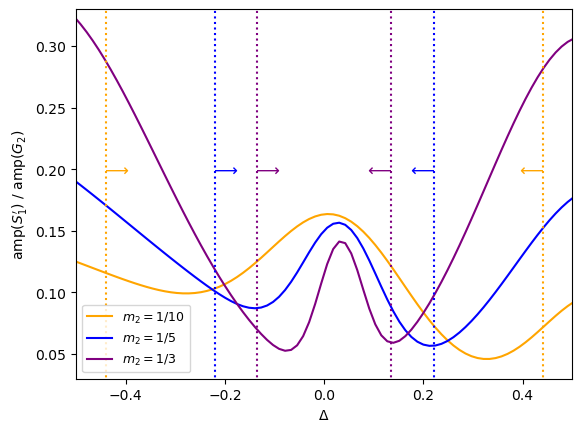

In [512]:
df = pd.read_csv('varyDelta.csv')
d1 = df[df['m2'] == 1/10]
d2 = df[df['m2'] == 1/5]
d3 = df[df['m2'] == 1/3]
xfit = np.linspace(-0.6,0.6,100)
x1,y1,fit1 = fitDelta(d1,xfit)
x2,y2,fit2 = fitDelta(d2,xfit)
x3,y3,fit3 = fitDelta(d3,xfit)

f, ax1 = plt.subplots()
c1, c2, c3 = 'orange', 'blue', 'purple'
# ax1.scatter(x1,y1,marker='.',color=c1,label='m2=1/10')
# ax1.scatter(x2,y2,marker='.',color=c2,label='m2=1/5')
# ax1.scatter(x3,y3,marker='.',color=c3,label='m2=1/3')
ax1.plot(xfit,fit1,color=c1,linestyle='-',label='$m_2=1/10$')
ax1.plot(xfit,fit2,color=c2,linestyle='-',label='$m_2=1/5$')
ax1.plot(xfit,fit3,color=c3,linestyle='-',label='$m_2=1/3$')

psibound = 0.3
ymin, ymax = 0, 0.36
b1, b2, b3 = deltaBound(1/10,psibound), deltaBound(1/5,psibound), deltaBound(1/3,psibound)
ax1.vlines([b1,-b1],ymin,ymax,linestyle=':',color=c1)
ax1.vlines([b2,-b2],ymin,ymax,linestyle=':',color=c2)
ax1.vlines([b3,-b3],ymin,ymax,linestyle=':',color=c3)

text_xpos = 0.20
ax1.text(b1-0.01,text_xpos,r'$\longrightarrow$', color=c1, fontsize=12, horizontalalignment='left', verticalalignment='center')
ax1.text(-b1+0.003,text_xpos,r'$\longleftarrow$', color=c1, fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(b2-0.01,text_xpos,r'$\longrightarrow$', color=c2, fontsize=12, horizontalalignment='left', verticalalignment='center')
ax1.text(-b2+0.003,text_xpos,r'$\longleftarrow$', color=c2, fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(b3-0.01,text_xpos,r'$\longrightarrow$', color=c3, fontsize=12, horizontalalignment='left', verticalalignment='center')
ax1.text(-b3+0.003,text_xpos,r'$\longleftarrow$', color=c3, fontsize=12, horizontalalignment='right', verticalalignment='center')

ax1.legend(loc='lower left',fontsize=9)
ax1.set_xlim(-0.5,0.5)
ax1.set_ylim(0.03,0.33)
ax1.set_xlabel('$\Delta$')
ax1.set_ylabel('amp($S_1\'$) / amp($G_2$)')

In [353]:
def solveAlpha1(a13, Delta):
    dfunc = lambda a1 : (a1**(-1/4)*(a13/a1)**(5/8)*(1-a1) - a1**(1/8)*(a13/a1)**(-1/2)*(1-(a13/a1))) / (a13**(-1/2)*(1-a13)) - Delta
    a1_initial_guess = 0.8
    a1_val = fsolve(dfunc, a1_initial_guess)
    return a1_val[0]

def solveAlpha2(a13, Delta):
    dfunc = lambda a2 : ((a13/a2)**(-1/4)*a2**(5/8)*(1-(a13/a2)) - (a13/a2)**(1/8)*a2**(-1/2)*(1-a2)) / (a13**(-1/2)*(1-a13)) - Delta
    a2_initial_guess = 0.8
    a2_val = fsolve(dfunc, a2_initial_guess)
    return a2_val[0]

In [404]:
delta = np.array([0.1,0.2,0.3,-0.4])
alpha_param = [[solveAlpha1(0.73, x), solveAlpha2(0.73, x)] for x in delta]
mass_param = np.linspace(1/10,1/3,10)
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3

data = np.zeros((len(mass_param)*len(alpha_param),14))
for i, (alpha1, alpha2) in enumerate(alpha_param):
    for j, m2 in enumerate(mass_param):
        mass = (1-m2)/2*1e-6, m2*1e-6, (1-m2)/2*1e-6
        sim = make_sim((alpha1, alpha2), mass, ecc, pomega)
        dist1, dist2 = modeDistance(sim)
        delta, psi_theo, psi_approx = calcPsi(sim)
        
        times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)
        amp_G1, amp_G2, amp_S1, amp_S2, amp_S1a, amp_S2a = amp(G1), amp(G2), amp(S1), amp(S2), amp(S1a), amp(S2a)
        
        data[i*len(mass_param)+j][:] = m2, delta, alpha1, alpha2, dist1, dist2, amp_G1, amp_G2, amp_S1, amp_S2, amp_S1a, amp_S2a, psi_theo, psi_approx

In [484]:
pd.set_option('display.max_rows', 40)
df = pd.DataFrame(data, columns=['m2','Delta','alpha12','alpha23','dist1','dist2','G1','G2','S1','S2','S1a','S2a','psi_theo','psi_approx'], index=None)
df

In [406]:
df.to_csv("varyM2.csv",index=False)

In [408]:
def linear(x,a,b):
    return a*x + b

In [409]:
def fitM2(d,xfit):
    x = [d.iloc[i]['m2'] for i in range(len(d)) if d.iloc[i]['S1'] < 0.1]
    y = [d.iloc[i]['S1a'] / d.iloc[i]['G2'] for i in range(len(d)) if d.iloc[i]['S1'] < 0.1]
    (popt, pcov) = curve_fit(linear, x, y, absolute_sigma=True,maxfev=90000)
    yfit = linear(xfit, *popt)
    return x,y,yfit

In [410]:
def m2Bound(delta,psi):
    m2Limit = lambda m2 : np.sqrt(m2)*((delta-1)**3*(delta+3)-(delta+1)**3*(delta-3))/((1-m2)*((delta-1)**3*(delta+3)+(delta+1)**3*(delta-3))) - psi
    m2_initial_guess = 1/4
    m2_bound = fsolve(m2Limit, m2_initial_guess)
    return m2_bound

Text(0, 0.5, "amp($S_1'$) / amp($G_2$)")

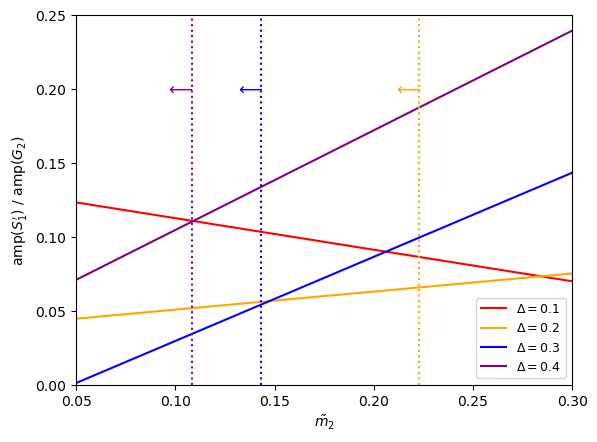

In [514]:
df = pd.read_csv('varyM2.csv')
d1 = df[df['Delta'].between(0.09,0.11)]
d2 = df[df['Delta'].between(0.19,0.21)]
d3 = df[df['Delta'].between(0.29,0.31)]
d4 = df[df['Delta'].between(-0.41,-0.39)]

xfit = np.linspace(1/20,1/3,100)
x1,y1,fit1 = fitM2(d1,xfit)
x2,y2,fit2 = fitM2(d2,xfit)
x3,y3,fit3 = fitM2(d3,xfit)
x4,y4,fit4 = fitM2(d4,xfit)

f, ax1 = plt.subplots()
c1, c2, c3, c4 = 'red', 'orange', 'blue', 'purple'
# ax1.scatter(x1,y1,marker='.',color=c1,label='$\Delta=0.1$')
# ax1.scatter(x2,y2,marker='.',color=c2,label='$\Delta=0.2$')
# ax1.scatter(x3,y3,marker='.',color=c3,label='$\Delta=0.3$')
# ax1.scatter(x4,y4,marker='.',color=c4,label='$\Delta=0.4$')
# ax1.legend()

ax1.plot(xfit,fit1,color=c1,linestyle='-',label='$\Delta=0.1$')
ax1.plot(xfit,fit2,color=c2,linestyle='-',label='$\Delta=0.2$')
ax1.plot(xfit,fit3,color=c3,linestyle='-',label='$\Delta=0.3$')
ax1.plot(xfit,fit4,color=c4,linestyle='-',label='$\Delta=0.4$')

psibound = 0.3
ymin, ymax = 0, 0.28
b1, b2, b3, b4 = m2Bound(0.1,-psibound), m2Bound(0.2,-psibound), m2Bound(0.3,-psibound), m2Bound(0.4,-psibound)
ax1.vlines([b1],ymin,ymax,linestyle=':',color=c1)
ax1.vlines([b2],ymin,ymax,linestyle=':',color=c2)
ax1.vlines([b3],ymin,ymax,linestyle=':',color=c3)
ax1.vlines([b4],ymin,ymax,linestyle=':',color=c4)

text_ypos = 0.2
# ax1.text(b2+0.001,text_xpos,r'$\longleftarrow$', color=c2, fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(b2+0.001,text_xpos,r'$\longleftarrow$', color=c2, fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(b3+0.001,text_xpos,r'$\longleftarrow$', color=c3, fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(b4+0.001,text_xpos,r'$\longleftarrow$', color=c4, fontsize=12, horizontalalignment='right', verticalalignment='center')

ax1.legend(loc='lower right',fontsize=9)
ax1.set_xlim(1/20,0.3)
ax1.set_ylim(0,0.25)
ax1.set_xlabel(r'$\tilde{m}_2$')
ax1.set_ylabel('amp($S_1\'$) / amp($G_2$)')

In [509]:
alpha = 0.9, 0.75
mass = 1e-7,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = -np.pi/3, 0, np.pi/3
sim = make_sim(alpha, mass, ecc, pomega)
calcPsi(sim)

# Test psi approximations

$$\sin{\psi} = \pm\sqrt{\frac{1}{2}-\frac{1}{2}\cdot\frac{(\tilde{m}_3-\tilde{m}_1\tilde{m}_2)b+(\tilde{m}_1-\tilde{m}_2\tilde{m}_3)a}{\sqrt{[(\tilde{m}_3+\tilde{m}_1\tilde{m}_2)b+(\tilde{m}_1+\tilde{m}_2\tilde{m}_3)a]^2-4ab\tilde{m}_2(\tilde{m}_1+\tilde{m}_3)^2}}}$$

$$\cos{\psi} = \pm\sqrt{\frac{1}{2}+\frac{1}{2}\cdot\frac{(\tilde{m}_3-\tilde{m}_1\tilde{m}_2)b+(\tilde{m}_1-\tilde{m}_2\tilde{m}_3)a}{\sqrt{[(\tilde{m}_3+\tilde{m}_1\tilde{m}_2)b+(\tilde{m}_1+\tilde{m}_2\tilde{m}_3)a]^2-4ab\tilde{m}_2(\tilde{m}_1+\tilde{m}_3)^2}}}$$

In [ ]:
def testPsi(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    m_tot = m1 + m2 + m3
     
    mu1, mu2, mu3 = m1/m_tot, m2/m_tot, m3/m_tot
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    
    ec12 = alpha12**(-1/4)*alpha23**(3/4)*alpha23**(-1/8)*(1-alpha12)
    ec23 = alpha23**(-1/2)*alpha12**(1/8)*(1-alpha23)
    ec13 = alpha13**(-1/2)*(1-alpha13)
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    phi_theo = 1/2*np.arctan(2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    sin_theo, cos_theo = np.sin(phi_theo), np.cos(phi_theo)
    
    Delta = (ec12 - ec23)/ec13
    mu = (mu3-mu1)/(mu1+mu3)
    a = (Delta-1)**3*(3+Delta)
    b = (Delta+1)**3*(Delta-3)
    
    frac = 2*np.sqrt(mu2)*(a-b)/((a-mu2*b)*np.sqrt((1-mu)/(1+mu)) + (b-mu2*a)*np.sqrt((1+mu)/(1-mu)))
    phi_lim = 1/2*math.atan(frac)  # 1/2*atan(2k/w), this is the best we could approximate
    sin_lim, cos_lim = np.sin(phi_lim), np.cos(phi_lim)
    
    num = (mu3-mu1*mu2)*b + (mu1-mu2*mu3)*a
#     denom = ((mu3+mu1*mu2)*b + (mu1+mu2*mu3)*a)**2 - 4*a*b*mu2*(mu1+mu3)**2
    denom = (1-mu2)*((mu2+mu3)*b-(mu1+mu2)*a)
    K = num/denom

#     num = (b*(1 + m*(-1 + mu) + mu) - a*(-1 + m + mu + m*mu))
#     denom = -4*(a-b)**2*m*(-1 + mu**2)
#     print(denom/num**2)
#     K = 1-1/2*denom/num**2
    sin_approx, cos_approx = np.sqrt(1/2)*np.sqrt(1-K), np.sqrt(1/2)*np.sqrt(1+K)
    
    
    phi_saa = -np.sqrt(mu1*mu2*mu3/(mu1+mu3)**4)*Delta/(3/16+1/2*(mu3-mu1)*Delta+3/8*Delta**2-Delta**4/16)
    sin_saa, cos_saa = np.sin(phi_saa), np.cos(phi_saa)

    print('Theoretical:')
    print(sin_theo, cos_theo)
    print('Upper limit:')
    print(sin_lim, cos_lim)
    print('Approximation:')
    print(sin_approx, cos_approx)
    print('SAA:')
    print(sin_saa, cos_saa)